<a href="https://colab.research.google.com/github/Sopralapanca/CommonLitChallenge/blob/main/Ablation_%2B_TrainLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/Sopralapanca/CommonLitChallenge.git"

fatal: destination path 'CommonLitChallenge' already exists and is not an empty directory.


In [2]:
!pip install transformers accelerate

In [3]:
import pandas as pd
import gc

train_path = "/content/CommonLitChallenge/data/dataset.zip"

train_data = pd.read_csv(train_path, compression='zip', sep=',', index_col=0)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7165 entries, 3b9047 to 814d6b
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   text                                  7165 non-null   object 
 1   content                               7165 non-null   float64
 2   wording                               7165 non-null   float64
 3   corrected_text                        7165 non-null   object 
 4   distance                              7165 non-null   int64  
 5   corrected_text_preprocessed           7165 non-null   object 
 6   text_pre_withstop                     7165 non-null   object 
 7   corrected_text_pre_withstop           7165 non-null   object 
 8   text_pos                              7165 non-null   float64
 9   summary_entities                      7165 non-null   object 
 10  summary_word_counter                  7165 non-null   int64  
 11  prompt_question

In [5]:
train_data.corrwith(train_data['content'])

<ipython-input-5-823b95b1fa0d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corrwith(train_data['content'])


content                                 1.000000
wording                                 0.751380
distance                                0.548770
text_pos                                0.598507
summary_word_counter                    0.791634
prompt_text_word_counter               -0.027778
word_counter_ratio                      0.802038
matching_entities                       0.310583
semantic_similarity                     0.389724
length_ratio                            0.777919
normalized_text_length                  0.780823
normalized_text_misspelled_counter      0.275465
normalized_2grams-cooccurrence-count    0.525949
normalized_2grams-correct-count         0.772036
normalized_3grams-cooccurrence-count    0.386953
normalized_3grams-correct-count         0.758222
normalized_4grams-cooccurrence-count    0.336304
normalized_4grams-correct-count         0.725661
normalized_karp_tfidf_scores            0.837687
dtype: float64

In [6]:
train_data.corrwith(train_data['wording'])

<ipython-input-6-96d862d8a2ba>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corrwith(train_data['wording'])


content                                 0.751380
wording                                 1.000000
distance                                0.332390
text_pos                                0.470060
summary_word_counter                    0.516272
prompt_text_word_counter               -0.134943
word_counter_ratio                      0.560617
matching_entities                       0.278965
semantic_similarity                     0.094257
length_ratio                            0.548927
normalized_text_length                  0.556560
normalized_text_misspelled_counter      0.218678
normalized_2grams-cooccurrence-count    0.181238
normalized_2grams-correct-count         0.560327
normalized_3grams-cooccurrence-count    0.037362
normalized_3grams-correct-count         0.548147
normalized_4grams-cooccurrence-count   -0.001812
normalized_4grams-correct-count         0.529339
normalized_karp_tfidf_scores            0.566616
dtype: float64

In [7]:
import numpy as np
print('Correlation with both targets CONTENT and WORDING if at least 1')
columns = train_data.select_dtypes(include=np.number).columns.tolist()
for i, (corr_content, corr_wording) in enumerate(zip(train_data.corrwith(train_data['content'], numeric_only=True), train_data.corrwith(train_data['wording'], numeric_only=True))):
  correlation = abs(corr_content)+abs(corr_wording)
  if correlation > 1:
    text = f'{columns[i]} \t\t\t {correlation}'
    if len(columns[i]) > 15:
      text = f'{columns[i]} \t\t {correlation}'
    elif len(columns[i]) > 20:
      text = f'{columns[i]} {correlation}'
    print(text)

Correlation with both targets CONTENT and WORDING if at least 1
content 			 1.7513804859701967
wording 			 1.7513804859701967
text_pos 			 1.0685667589058232
summary_word_counter 		 1.3079063942668798
word_counter_ratio 		 1.3626555406276393
length_ratio 			 1.3268466288723135
normalized_text_length 		 1.3373822553558221
normalized_2grams-correct-count 		 1.3323631065715127
normalized_3grams-correct-count 		 1.3063687628501657
normalized_4grams-correct-count 		 1.2550000157810022
normalized_karp_tfidf_scores 		 1.4043034226258029


# Data prepatation for the LLM

In [8]:
def oversample_df(df):
    """
    :param df: Dataframe to be overampled based on prompt_id
    :return: Dataframe oversampled
    """
    classes = df["prompt_id"].value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df["prompt_id"] == key])
    classes_sample = []
    for i in range(1, len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe, classes_list[0]], axis=0)

    return final_df

In [9]:
import copy
import numpy as np
import more_itertools

import torch
from torch.utils.data import Sampler, Dataset, DataLoader

class SmartBatchingDataset(Dataset):
    def __init__(self, df, tokenizer, input_cols, target_cols, features_cols):
        super(SmartBatchingDataset, self).__init__()

        input_df = copy.deepcopy(df[input_cols])
        features_df = copy.deepcopy(df[features_cols])

        # Combine strings from multiple columns with [CLS], [SEP], and [SEP] separators
        input_df['combined_col'] = input_df.apply(
            lambda row: tokenizer.cls_token + ' ' + f' {tokenizer.sep_token} '.join(row) + f' {tokenizer.sep_token}',
            axis=1)

        self._data = [
            input_df['combined_col'].apply(tokenizer.tokenize).apply(tokenizer.convert_tokens_to_ids).to_list(),
            features_df.values.tolist()]
        self._targets = df[target_cols].values.tolist() if target_cols is not None else None
        self.sampler = None

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item):
        if self._targets is not None:
            return [self._data[0][item], self._data[1][item]], self._targets[item]
        else:
            return [self._data[0][item], self._data[1][item]]

    def get_dataloader(self, batch_size, max_len, pad_id):

        self.sampler = SmartBatchingSampler(
            data_source=self._data[0],
            batch_size=batch_size
        )
        collate_fn = SmartBatchingCollate(
            targets=self._targets,
            max_length=max_len,
            pad_token_id=pad_id
        )
        dataloader = DataLoader(
            dataset=self,
            batch_size=batch_size,
            sampler=self.sampler,
            collate_fn=collate_fn,
            pin_memory=True,
            num_workers=1 # calcolare grafico con i tempi impiegati per capire qual è il numero di worker migliore da utilizzare
        )
        return dataloader


class SmartBatchingSampler(Sampler):
    def __init__(self, data_source, batch_size):
        super(SmartBatchingSampler, self).__init__(data_source)
        self.len = len(data_source)
        sample_lengths = [len(seq) for seq in data_source]
        argsort_inds = np.argsort(sample_lengths)
        self.batches = list(more_itertools.chunked(argsort_inds, n=batch_size))
        self._backsort_inds = None

    def __iter__(self):
        if self.batches:
            last_batch = self.batches.pop(-1)
            np.random.shuffle(self.batches)
            self.batches.append(last_batch)
        self._inds = list(more_itertools.flatten(self.batches))
        yield from self._inds

    def __len__(self):
        return self.len

    @property
    def backsort_inds(self):
        if self._backsort_inds is None:
            self._backsort_inds = np.argsort(self._inds)
        return self._backsort_inds


class SmartBatchingCollate:
    def __init__(self, targets, max_length, pad_token_id):
        self._targets = targets
        self._max_length = max_length
        self._pad_token_id = pad_token_id

    def __call__(self, batch):
        if self._targets is not None:
            sequences, targets = list(zip(*batch))
        else:
            sequences = list(batch)

        ids = []
        features = []
        for i in range(len(sequences)):
            ids.append(sequences[i][0])
            features.append(sequences[i][1])

        input_ids, attention_mask = self.pad_sequence(
            ids,
            max_sequence_length=self._max_length,
            pad_token_id=self._pad_token_id
        )

        if self._targets is not None:
            output = [input_ids, features], attention_mask, torch.tensor(targets)
        else:
            output = [input_ids, features], attention_mask
        return output

    def pad_sequence(self, sequence_batch, max_sequence_length, pad_token_id):
        max_batch_len = max(len(sequence) for sequence in sequence_batch)
        max_len = min(max_batch_len, max_sequence_length)
        padded_sequences, attention_masks = [[] for i in range(2)]
        attend, no_attend = 1, 0
        for sequence in sequence_batch:



            # As discussed above, truncate if exceeds max_len
            new_sequence = list(sequence[:max_len])


            attention_mask = [attend] * len(new_sequence)
            pad_length = max_len - len(new_sequence)

            new_sequence.extend([pad_token_id] * pad_length)
            attention_mask.extend([no_attend] * pad_length)

            padded_sequences.append(new_sequence)
            attention_masks.append(attention_mask)

        padded_sequences = torch.tensor(padded_sequences)
        attention_masks = torch.tensor(attention_masks)

        return padded_sequences, attention_masks


In [10]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


def pipeline(config, training_data, input_cols, target_cols, features, split=0.2, oversample=False, return_test_loader=True):
    """
    :param config:          model configuration dictionary
    :param training_data:   dataframe object with representing the dataset
    :param input_cols:      list of strings defining the columns of the dataframe that needs to be input of the LLM
    :param target_cols:     list of strings defining the columns of the dataframe for the target
    :param features:        list of strings defining the columns of the dataframe that rapresent the added feature to be concatenated as input to the feedforward net
    :param split:           float, percentage of the size of the validation set and test set
    :param oversample:      boolean, if true the training set will be oversampled
    :return:                training, validation, test loaders and the tokenizer used
    """

    train, valid = train_test_split(training_data, test_size=split, random_state=42, stratify=training_data["prompt_id"])

    if return_test_loader:
      train, test = train_test_split(train, test_size=split, random_state=42, stratify=train["prompt_id"])

    if oversample:
        train = oversample_df(train)

    tokenizer = AutoTokenizer.from_pretrained(config['model'])

    train_set = SmartBatchingDataset(train, tokenizer, input_cols, target_cols, features_cols=features)
    valid_set = SmartBatchingDataset(valid, tokenizer, input_cols, target_cols, features_cols=features)

    train_loader = train_set.get_dataloader(batch_size=config['batch_size'], max_len=config["max_length"],
                                            pad_id=tokenizer.pad_token_id)

    valid_loader = valid_set.get_dataloader(batch_size=config['batch_size'], max_len=config["max_length"],
                                            pad_id=tokenizer.pad_token_id)
    if return_test_loader:
      test_set = SmartBatchingDataset(test, tokenizer, input_cols, target_cols, features_cols=features)
      test_loader = test_set.get_dataloader(batch_size=config['batch_size'], max_len=config["max_length"],
                                          pad_id=tokenizer.pad_token_id)

      return train_loader, valid_loader, test_loader, tokenizer

    else:
        return train_loader, valid_loader, tokenizer

# Model Definition

In [11]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class RegressorModel(nn.Module):
    def __init__(self, name, fflayers, ffdropout,
                 features_dim, target_cols, activation_function,
                 freeze_encoder=True,pooling="mean-pooling", dropoutLLM=False):
        super(RegressorModel, self).__init__()

        """
        :param name:                strings, model name to be downloaded with huggingsface transformers
        :param fflayers:            int, number of layers of the feedforward network
        :param ffdropout:           float, percentage of dropout between LLM embeddings and feedforward net
        :param features_dim:        int, dimension of the feature extracted
        :param target_cols:         list of strings, columns of the dataframe that represents the target
        :param activation_function: string, activation function to use
        :param freeze_encoder:      boolean, if True the LLM is freezed and will be not trained
        :param pooling:             strings, pooling method to user
        :param dropoutLLM:          boolean, if False dropout percentage of LLM will be setted to 0
        """


        self.model_name = name
        self.pooling = pooling
        self.model_config = AutoConfig.from_pretrained(self.model_name)
        self.target_cols = target_cols
        self.drop = nn.Dropout(p=ffdropout)
        self.fflayers = fflayers


        if not dropoutLLM:
            self.model_config.hidden_dropout_prob = 0.0
            self.model_config.attention_probs_dropout_prob = 0.0

        self.encoder = AutoModel.from_pretrained(self.model_name, config=self.model_config)

        if freeze_encoder:
            for param in self.encoder.base_model.parameters():
                param.requires_grad = False

        size = self.encoder.config.hidden_size + features_dim
        # The output layer that takes the last hidden layer of the BERT model
        self.cls_layer1 = nn.Linear(size, 2*size)



        self.ff_hidden_layers = nn.ModuleList()

        size = 2*size
        for _ in range(self.fflayers):
            out_size = int(size/2)
            self.ff_hidden_layers.append(nn.Linear(size, out_size))
            size = out_size


        self.act = None
        if activation_function == 'relu':
            self.act = nn.ReLU()

        if activation_function == 'leaky-relu':
            self.act = nn.LeakyReLU()

        # last layer
        self.output_layer = nn.Linear(size, len(self.target_cols))

    def forward(self, inputs, attention_mask):

        input_ids = inputs[0]
        features = inputs[1]

        features = torch.tensor(features).float().to(input_ids.device)

        # Feed the input to Bert model to obtain contextualized representations
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask,
                               output_hidden_states=False)

        if self.pooling == 'cls':
            # Obtain the representations of [CLS] heads
            logits = outputs.last_hidden_state[:, 0, :]

        if self.pooling == 'mean-pooling':
            last_hidden_state = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            logits = sum_embeddings / sum_mask


        combined_features = torch.cat((logits, features), dim=1) # combine bert embeddings with features extracted from the dataset

        output = self.drop(combined_features)
        output = self.act(self.cls_layer1(output))


        for hl in self.ff_hidden_layers:
            output = self.act(hl(output))

        output = self.output_layer(output)
        return output

# Training Loop

In [12]:
class EarlyStopper:
    def __init__(self, checkpoint_path="", patience=5, min_delta=0.003):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.checkpoint_path = checkpoint_path

    def early_stop(self, validation_loss, epoch, optimizer, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            name = f"checkpoint.pt"
            full_path = self.checkpoint_path + name

            print(f"New best validation loss, saving checkpoint at {full_path}")

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': validation_loss,
            }, full_path)


        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [13]:
class Trainer:
    def __init__(self, model, loaders, epochs, accelerator, lr, weight_decay):

        """
        :param model:       PyTorch model to train
        :param loaders:     tuple of DataLoaders, (train loader, valid loader)
        :param epochs:      int, max epochs to train a model
        :param accelerator: PyTorch device, device for gradient step accumulation
        :param lr:          float, learning rate
        """

        self.model = model
        self.train_loader, self.val_loader = loaders
        self.weight_decay = weight_decay


        self.epochs = epochs

        self.accelerator = accelerator

        self.lr = lr

        self.optim = self._get_optim()

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5, eta_min=1e-7)

        self.train_losses = {
            "loss": [],
            "content": [],
            "wording": []
        }
        self.val_losses = {
            "loss": [],
            "content": [],
            "wording": []
        }

    def prepare(self):
        self.model, self.optim, self.train_loader, self.val_loader, self.scheduler = self.accelerator.prepare(
            self.model,
            self.optim,
            self.train_loader,
            self.val_loader,
            self.scheduler
        )

    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.lr, eps=1e-6)
        return optimizer

    def loss_fn(self, outputs, targets, multioutput=True):
        colwise_rmse = torch.sqrt(torch.mean((targets - outputs) ** 2, dim=0))
        if multioutput:
            content_loss = colwise_rmse[0]
            wording_loss = colwise_rmse[1]
        else:
            content_loss = 0.
            wording_loss = 0.

        loss = torch.mean(colwise_rmse, dim=0)

        return loss, content_loss, wording_loss

    def train_one_epoch(self, epoch, multioutput, outer_progress="", verbose=True):

        running_loss = 0.
        c_loss = 0.
        w_loss = 0.

        inner_iterations = len(self.train_loader)

        idx = 0
        for el in self.train_loader:
            input_ids, attention_mask, target = el

            with self.accelerator.accumulate(self.model):
                output = self.model(inputs=input_ids, attention_mask=attention_mask)

                loss, content_loss, wording_loss = self.loss_fn(output, target, multioutput)
                running_loss += loss.item()
                c_loss += content_loss
                w_loss += wording_loss

                self.accelerator.backward(loss)

                self.optim.step()

                self.scheduler.step(epoch - 1 + idx / len(self.train_loader))

                self.optim.zero_grad()

                del input_ids, attention_mask, target, loss

                if verbose:
                    inner_progress = f"Training Batch: [{idx}/{inner_iterations}]"
                    print(f"\r{outer_progress} {inner_progress}", end="")

            idx += 1

        train_loss = running_loss / len(self.train_loader)
        c_loss = c_loss / len(self.train_loader)
        w_loss = w_loss / len(self.train_loader)
        self.train_losses["loss"].append(train_loss)
        self.train_losses["content"].append(c_loss)
        self.train_losses["wording"].append(w_loss)

        if verbose:
            inner_progress = f"Training Batch:[{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]}"
            print(f"\r{outer_progress} {inner_progress}", end="")

    @torch.no_grad()
    def valid_one_epoch(self, epoch, multioutput, outer_progress="", verbose=True):

        running_loss = 0.
        c_loss = 0.
        w_loss = 0.

        inner_iterations = len(self.val_loader)

        idx = 0
        for input_ids, attention_mask, target in self.val_loader:
            output = self.model(inputs=input_ids, attention_mask=attention_mask)

            loss, content_loss, wording_loss = self.loss_fn(output, target, multioutput)
            running_loss += loss.item()
            c_loss += content_loss
            w_loss += wording_loss

            del input_ids, attention_mask, target, loss

            if verbose:
                inner_progress = f"Validation Batch: [{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]}"
                print(f"\r{outer_progress} {inner_progress}", end="")

            idx += 1

        val_loss = running_loss / len(self.val_loader)
        c_loss = c_loss / len(self.val_loader)
        w_loss = w_loss / len(self.val_loader)
        self.val_losses["loss"].append(val_loss)
        self.val_losses["content"].append(c_loss)
        self.val_losses["wording"].append(w_loss)

        if verbose:
            inner_progress = f"Validation Batch:[{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]} validation loss: {self.val_losses['loss'][-1]}"
            print(f"\r{outer_progress} {inner_progress}", end="")

    def test(self, test_loader):

        preds = []
        for (inputs) in test_loader:
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())

        preds = torch.concat(preds)
        return preds

    def fit(self, multioutput=True, min_delta=0.003, verbose=True):

        self.prepare()

        # Define the number of iterations for both loops
        outer_iterations = self.epochs

        early_stopper = EarlyStopper(patience=2, min_delta=min_delta)
        outer_progress = ""

        # Create outer progress bar
        for epoch in range(1, outer_iterations + 1):
            if verbose:
                outer_progress = f"Epoch: {epoch}/{outer_iterations}"

            self.model.train()

            self.train_one_epoch(epoch, multioutput, outer_progress=outer_progress, verbose=verbose)
            self.clear()

            self.model.eval()
            self.valid_one_epoch(epoch, multioutput, outer_progress=outer_progress, verbose=verbose)

            self.clear()

            if early_stopper.early_stop(validation_loss=self.val_losses["loss"][-1],
                                        epoch=epoch, optimizer=self.optim, model=self.model):
                break

            if verbose:
                print()

        if verbose:
            print("\nTraining completed!")

        return self.train_losses, self.val_losses

    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

# Model Training

In [14]:
import matplotlib.pyplot as plt
import os

def plot_and_save_graph(epochs, model_name, train_losses, val_losses, save=False):
    try:
      os.mkdir('plots')
    except:
      print('Already There!')
    # Create the plot
    plt.figure(figsize=(10, 6))

    e = [x for x in range(1, epochs+1)]

    plt.plot(e, train_losses, label='Training Loss')
    plt.plot(e, val_losses, label='Validation Loss')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(model_name)
    plt.legend()
    plt.grid()

    # Save the plot to a file
    if save:
      plt.savefig(f'./plots/{model_name}.png')
      return

    # Display the plot
    plt.show()

In [15]:
restricted_train_data = train_data.drop(columns=["normalized_text_misspelled_counter", "normalized_3grams-cooccurrence-count", "normalized_4grams-cooccurrence-count"], axis=1)

Froim the run of **25th** of September the results on the ablation tests yields that **normalized_text_length** feature can be removed...

'model-name': 'bert cased'

{'removed_feat': 'text_pos', 'best-valid-loss': 0.5443077306146409}

{'removed_feat': 'summary_word_counter', 'best-valid-loss': 0.5197304647447007}

{'removed_feat': 'word_counter_ratio', 'best-valid-loss': 0.5116158095408947}

{'removed_feat': 'length_ratio', 'best-valid-loss': 0.5086068489425362}

{'removed_feat': 'normalized_text_length','best-valid-loss': 0.5013982147227423}

{'removed_feat': 'normalized_2grams-correct-count', 'best-valid-loss': 0.5039442063706167}

{'removed_feat': 'normalized_3grams-correct-count', 'best-valid-loss': 0.505915270957442}

{'removed_feat': 'normalized_4grams-correct-count', 'best-valid-loss': 0.5050030506337918}

{'removed_feat': 'normalized_karp_tfidf_scores',  'best-valid-loss': 0.5110561320542625}

Froim the run of **26h** of September the results on the ablation tests yields that **normalized_text_length** feature can be removed...

'model-name': 'bert cased'

{'removed_feat': 'text_pos', 'best-valid-loss': 0.5308328929634811}

{'removed_feat': 'summary_word_counter', 'best-valid-loss': 0.5146219485898536}

{'removed_feat': 'word_counter_ratio',  'best-valid-loss': 0.5112329404749246}

{'removed_feat': 'length_ratio', 'best-valid-loss': 0.5051728214726142}

{'removed_feat': 'normalized_2grams-correct-count',  'best-valid-loss': 0.5102488355176694}

{'removed_feat': 'normalized_3grams-correct-count', 'best-valid-loss': 0.5093000588476824}

{'removed_feat': 'normalized_4grams-correct-count', 'best-valid-loss': 0.5094546395922106}

{'removed_feat': 'normalized_karp_tfidf_scores', 'best-valid-loss': 0.5114946525990133}

In [ ]:
from accelerate import Accelerator
import time

config = {
    'model': 'bert-base-cased', # name of the model to be downloaded with huggingsface transformers
    'name': 'bert cased', # name of the model to be displayed on the results
    'max_length': 512,
    'batch_size': 4,  # si può provare ad aumentare ma occhio agli out of memory error
    'epochs': 40,
    'lr': 7e-4,
    'gradient_accumulation_steps': 16,
    'adam_eps': 1e-6,  # 1e-8 default
    'freeze_encoder': True,
    'fflayers': 3,
    'ffdropout': 0.05,
    'activation_function': 'relu',
    'weight_decay': 0.001
}

features = ["text_pos", "summary_word_counter", "word_counter_ratio", "normalized_text_length",
  "length_ratio", "normalized_2grams-correct-count", "normalized_3grams-correct-count",
  "normalized_4grams-correct-count", "normalized_karp_tfidf_scores"]
feature_dim = len(features)
multioutput = True

input_cols = ["prompt_question", "corrected_text_preprocessed"]
target_cols = ["content","wording"]

restricted_train_data.reset_index(inplace=True)

accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])

model = RegressorModel(name=config["model"], fflayers=config["fflayers"],
                       ffdropout=config["ffdropout"],activation_function=config["activation_function"],
                       features_dim=feature_dim, target_cols=target_cols).to(device=accelerator.device)

Epoch: 1/40 Validation Batch:[359/359] training loss: 0.6619340724445422 validation loss: 0.5949880864709864New best validation loss, saving checkpoint at checkpoint.pt

Epoch: 2/40 Validation Batch:[359/359] training loss: 0.5665188606887852 validation loss: 0.5795729872160967New best validation loss, saving checkpoint at checkpoint.pt

Epoch: 3/40 Validation Batch:[359/359] training loss: 0.5504596427637425 validation loss: 0.5735854372423671New best validation loss, saving checkpoint at checkpoint.pt

Epoch: 4/40 Validation Batch:[359/359] training loss: 0.5308951760897513 validation loss: 0.5512624595075597New best validation loss, saving checkpoint at checkpoint.pt

Epoch: 5/40 Validation Batch:[359/359] training loss: 0.5199215252718965 validation loss: 0.5481703617612631New best validation loss, saving checkpoint at checkpoint.pt

Epoch: 6/40 Validation Batch:[359/359] training loss: 0.5506742397038975 validation loss: 0.5726854298108135
Epoch: 7/40 Validation Batch:[359/359] tr

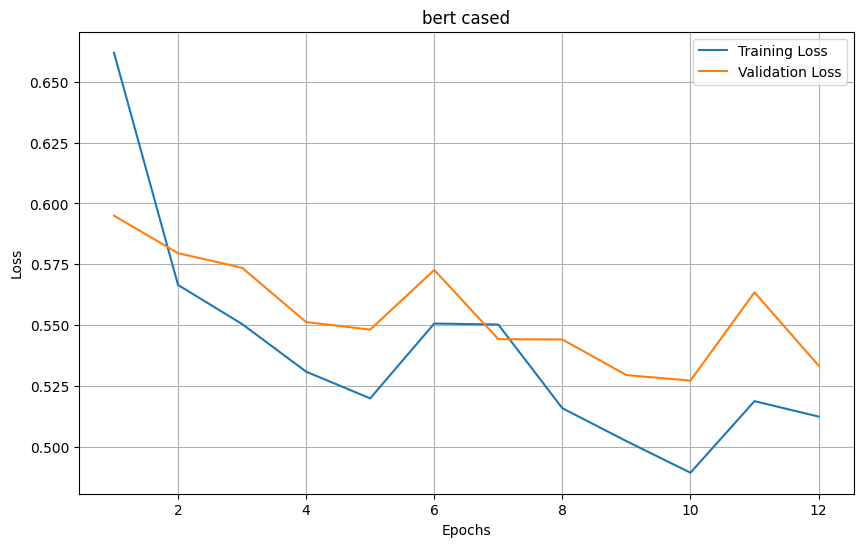

In [19]:

train_loader, valid_loader, test_loader, tokenizer = pipeline(config, training_data=restricted_train_data, input_cols=input_cols, target_cols=target_cols,
                                                            features=features, split=0.2, oversample=True)

trainer = Trainer(model, (train_loader, valid_loader), epochs=config['epochs'], accelerator=accelerator, lr=config["lr"], weight_decay=config["weight_decay"])

start_time = time.time()
train_losses, val_losses = trainer.fit(multioutput)
elapsed_time = time.time() - start_time

plot_and_save_graph(len(train_losses["loss"]), config['name'], train_losses["loss"], val_losses["loss"], save=True)

training_info = {
      'train-loss': train_losses["loss"][-1],
      'valid-loss': val_losses["loss"][-1],
      'train-content-loss': train_losses["content"][-1].item(),
      'valid-content-loss': val_losses["content"][-1].item(),
      'train-wording-loss': train_losses["wording"][-1].item(),
      'valid-wording-loss': val_losses["wording"][-1].item(),
      'best-valid-loss': min(val_losses["loss"]),
  }
print(training_info)

In [20]:
# ABLATION TEST
# f = open("results.txt", "a")
# f.write(f"'model-name': {config['name']}\n")
# for i in range(0, feature_dim):
#   abl_features = features.copy()
#   removed_feat = abl_features.pop(i)
#   title = str(removed_feat) + str(config["name"])
#   train_loader, valid_loader, test_loader, tokenizer = pipeline(config, training_data=restricted_train_data, input_cols=input_cols, target_cols=target_cols,
#                                                               features=abl_features, split=0.2, oversample=True)

#   trainer = Trainer(model, (train_loader, valid_loader), epochs=config['epochs'], accelerator=accelerator, lr=config["lr"], weight_decay=config["weight_decay"])

#   start_time = time.time()
#   train_losses, val_losses = trainer.fit(multioutput)
#   elapsed_time = time.time() - start_time

#   plot_and_save_graph(len(train_losses["loss"]), title, train_losses["loss"], val_losses["loss"], save=True)

#   training_info = {
#         'removed_feat': removed_feat,
#         'train-loss': train_losses["loss"][-1],
#         'valid-loss': val_losses["loss"][-1],
#         'train-content-loss': train_losses["content"][-1].item(),
#         'valid-content-loss': val_losses["content"][-1].item(),
#         'train-wording-loss': train_losses["wording"][-1].item(),
#         'valid-wording-loss': val_losses["wording"][-1].item(),
#         'best-valid-loss': min(val_losses["loss"]),
#     }

#   f.write(str(training_info))
# f.close()

# Evaluation on internal test set

In [21]:
def evaluate(test_loader, model, device, trainer):

    preds = []
    running_loss = 0.
    for el in test_loader:
        input_ids, attention_mask, target = el

        attention_mask = attention_mask.to(device)
        target = target.to(device)

        ids = input_ids[0].to(device)
        inputs = [ids, input_ids[1]]

        output = model(inputs=inputs, attention_mask=attention_mask)
        loss, content_loss, wording_loss = trainer.loss_fn(output, target, multioutput)
        running_loss += loss.item()

        preds.append(output)

    test_loss = running_loss / len(test_loader)
    print("Test Loss:", test_loss)
    preds = torch.concat(preds)
    return preds

In [22]:
checkpoint = torch.load("./checkpoint.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
evaluate(test_loader=test_loader, model=model, trainer=trainer, device=accelerator.device)


Test Loss: 0.5225720819384378


tensor([[-1.2391, -1.0574],
        [ 0.0410, -0.2035],
        [-0.6329, -0.4618],
        ...,
        [ 3.0047,  1.4014],
        [ 4.4817,  3.2623],
        [ 4.0106,  1.9848]], device='cuda:0', grad_fn=<CatBackward0>)